In [36]:
import pandas as pd
import numpy as np 
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import sklearn 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline 

In [2]:
sns.set_theme(context = 'notebook', style = 'darkgrid')

In [3]:
df = pd.read_csv(ZipFile("data/GoodReads_100k_books.csv.zip").open('GoodReads_100k_books.csv'))

In [4]:
df.head()

,author,bookformat,desc,genre,img,isbn,isbn13,link,pages,rating,reviews,title,totalratings
0,Laurence M. Hauptman,Hardcover,Reveals that several hundred thousand Indians ...,"History,Military History,Civil War,American Hi...",https://i.gr-assets.com/images/S/compressed.ph...,002914180X,9.78E+12,https://goodreads.com/book/show/1001053.Betwee...,0,3.52,5,Between Two Fires: American Indians in the Civ...,33
1,"Charlotte Fiell,Emmanuelle Dirix",Paperback,Fashion Sourcebook - 1920s is the first book i...,"Couture,Fashion,Historical,Art,Nonfiction",https://i.gr-assets.com/images/S/compressed.ph...,1906863482,9.78E+12,https://goodreads.com/book/show/10010552-fashi...,576,4.51,6,Fashion Sourcebook 1920s,41
2,Andy Anderson,Paperback,The seminal history and analysis of the Hungar...,"Politics,History",https://i.gr-assets.com/images/S/compressed.ph...,948984147,9.78E+12,https://goodreads.com/book/show/1001077.Hungar...,124,4.15,2,Hungary 56,26
3,Carlotta R. Anderson,Hardcover,"""All-American Anarchist"" chronicles the life a...","Labor,History",https://i.gr-assets.com/images/S/compressed.ph...,814327079,9.78E+12,https://goodreads.com/book/show/1001079.All_Am...,324,3.83,1,All-American Anarchist: Joseph A. Labadie and ...,6
4,Jean Leveille,NaN,"Aujourdâ€™hui, lâ€™oiseau nous invite Ã sa ta...",NaN,https://i.gr-assets.com/images/S/compressed.ph...,2761920813,NaN,https://goodreads.com/book/show/10010880-les-o...,177,4.00,1,Les oiseaux gourmands,1


<h2>Prepare Data</h2>

In [5]:
df = df.dropna(subset = ['desc', 'genre'])

In [6]:
df['genres'] = df.genre.apply(lambda s: str(s).split(","))

In [7]:
df.genres.apply(len).mean(), df.genres.apply(len).median()

(9.369795870620576, 10.0)

[Text(0.5, 1.0, 'Histogram of the Number of Categories Per Book'),
 Text(0.5, 0, 'Number of Categories'),
 Text(0, 0.5, 'Density')]

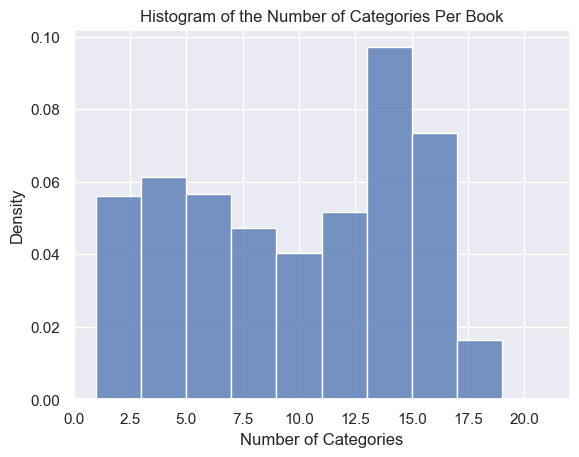

In [8]:
f = sns.histplot(df.genres.apply(len), stat = 'density', binwidth = 2)
f.set(title = 'Histogram of the Number of Categories Per Book', xlabel = 'Number of Categories', 
      ylabel = 'Density')

In [9]:
all_genres = df.explode("genres")

<h3>See Distribution of Classes</h3>

In [10]:
genre_counts = all_genres.genres.value_counts()

In [11]:
genre_counts.mean(), genre_counts.median()

(679.3698049194232, 104.0)

[Text(0.5, 1.0, 'Log Distribution'), Text(0.5, 0, 'Log Number of Occurences')]

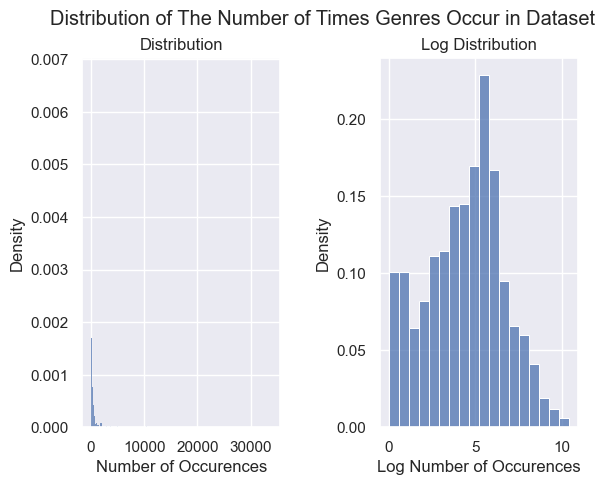

In [12]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

f1 = sns.histplot(genre_counts, stat = 'density', ax = ax[0])
f2 = sns.histplot(np.log(genre_counts), stat = 'density', ax = ax[1])

f.suptitle('Distribution of The Number of Times Genres Occur in Dataset')
f1.set(title = 'Distribution', xlabel = 'Number of Occurences')
f2.set(title = 'Log Distribution', xlabel = 'Log Number of Occurences')

In [13]:
top_genres = genre_counts.sort_values(ascending = False)[:50]

<h3>Remove Uncommon Classes</h3>

In [103]:
all_genres = all_genres[all_genres.apply(lambda s: s.genres in top_genres.index, axis = 1)]

In [105]:
x = all_genres['desc']
y = all_genres['genres']

<h2>Naive Bayes Classifier</h2>

In [106]:
x_train, x_test, y_train, y_test  = train_test_split(x, y, random_state = 42, stratify = y) 

In [107]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(x_train)

X_counts.shape

(230616, 276191)

In [108]:
tf = TfidfTransformer(use_idf = False)
X_tf = tf.fit_transform(X_counts)

X_tf.shape

(230616, 276191)

In [109]:
X_tf

<230616x276191 sparse matrix of type '<class 'numpy.float64'>'
	with 21771280 stored elements in Compressed Sparse Row format>

In [110]:
mnb = MultinomialNB().fit(X_tf, y_train)

In [111]:
new = [['a book about a frog who falls in love'], ['once upon a time there was a frog'],
       ['frogs! in space! galatic! aliens! lasers! the frog has a laser, oh no, what will he do'], 
       ['the true story of the real horace frog a true tale of a real frog'], 
       ['my journey: after 50 years, I am finally telling my truth']]
sample_predictions = []

for i in range(len(new)):
    x_new_counts = count_vect.transform(new[i])
    x_new_tf = tf.transform(x_new_counts)
    predicted = mnb.predict(x_new_tf)
    sample_predictions.append(predicted)

In [112]:
sample_predictions

[array(['Romance'], dtype='<U19'),
 array(['Fantasy'], dtype='<U19'),
 array(['Fantasy'], dtype='<U19'),
 array(['Fantasy'], dtype='<U19'),
 array(['Romance'], dtype='<U19')]

In [113]:
x_test_counts = count_vect.transform(x_test)
x_test_tf = tf.transform(x_test_counts)
y_pred = mnb.predict(x_test_tf) 

In [131]:
outputs = pd.concat([pd.Series(y_test.values), pd.Series(y_pred)], axis = 1)
outputs.columns = ['true', 'predicted']

In [133]:
y_test.nunique()

20

In [136]:
pd.crosstab(outputs.predicted, outputs.true).shape

(13, 20)

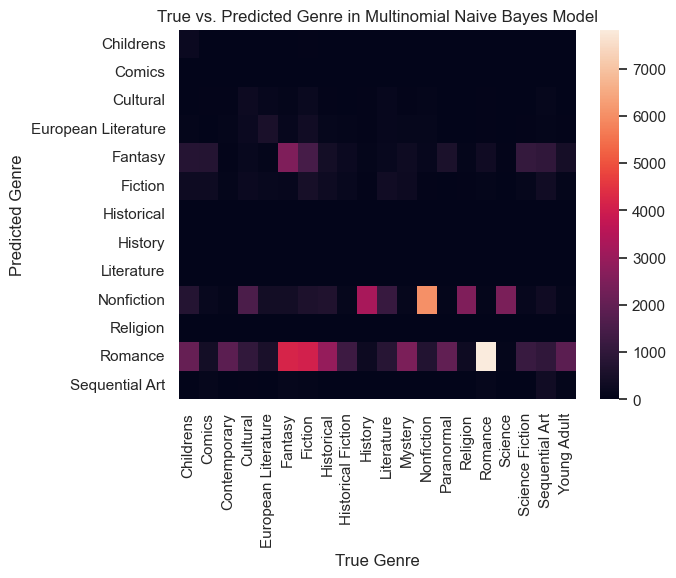

In [130]:
f = sns.heatmap(pd.crosstab(outputs.predicted, outputs.true)) 

_ = f.set(title = 'True vs. Predicted Genre in Multinomial Naive Bayes Model', 
      xlabel = 'True Genre', ylabel = 'Predicted Genre')

In [116]:
print(accuracy_score(y_test, y_pred))


0.23853939015506295


In [19]:
svd = TruncatedSVD(n_components = 100, random_state = 42)
X_transform = svd.fit_transform(X_tf)

In [20]:
svd.explained_variance_.sum()

In [ ]:
X = admit.drop(['Chance of Admit', 'admitted'], axis = 1)
X_scaled = scale(X)
pca = PCA(n_components = 2, random_state = 42)
X_pca = pca.fit_transform(X)

<h2>Text Processing</h2>

In [ ]:
shuffle = StratifiedShuffleSplit(y, test_size = 0.8, random_state = 42)

In [ ]:
for train_index, test_index in shuffle:
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [ ]:
tf = TfidfTransformer(use_idf = False).fit_transform(X_counts)
X_tf.shape